In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/dnanhkhoa/nb_black.git
%load_ext nb_black

  Cloning https://github.com/dnanhkhoa/nb_black.git to /tmp/pip-req-build-phsupva8
  Running command git clone --filter=blob:none --quiet https://github.com/dnanhkhoa/nb_black.git /tmp/pip-req-build-phsupva8
  Resolved https://github.com/dnanhkhoa/nb_black.git to commit 50c0f1bbfee53a7dfd76b00a6b0a5ac82a729386
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.6 MB/s eta 0:00:00
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5343 sha256=f8f5a6d61b4bf78cd918fc7e98445c39dc303b04992a007b65eb873b96d49e29
  Stored in directory: /tmp/pip-ephem-wheel-cache-egt5725y/wheels/e4/66/32/7601c8bcaced0d4494f052284f51da58f3590fa1224ec6c7b8
Successfully built nb-black


<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models import resnet50, ResNet50_Weights, resnet18
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
import sys
from PIL import Image, ImageFile
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time
import os
from torchsummary import summary

import matplotlib.pyplot as plt
import seaborn as sns

print("Setup complete")

Setup complete


In [3]:
def show_transformed_images(dataset):
  '''Plot random images after transformation'''
  loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(5, 5))
  plt.imshow(np.transpose(grid, (1, 2, 0)))
  print('Labels ', labels)

In [4]:
def set_device():
    '''the device on which to perform computations'''

    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return torch.device(device)


In [16]:
def calculate_class_weights(dataset_path):
    '''Calculating weights for each class, because dataset is imbalanced'''
    all_files = []
    all_labels = []
    for class_label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_label)
        class_files = os.listdir(class_path)

        all_files.extend(class_files)
        all_labels.extend([class_label] * len(class_files))

    class_weights = compute_class_weight(
        'balanced', classes=np.unique(all_labels), y=all_labels
        )

    normalized_weights = class_weights / sum(class_weights)
    class_weights_tensor = torch.tensor(normalized_weights, dtype=torch.float32)

    return class_weights_tensor

In [44]:
def train_nn(model, train_loader, validation_loader, criterion, optimizer,
             n_epochs, patience=3, class_weights=None):
    '''
    Training model, using early stopping and plotting best performed epoch.
    Also saving the model if no improvement. At this point testing on validation
    set.
    '''

    ImageFile.LOAD_TRUNCATED_IMAGES = True
    device = set_device()
    best_accuracy = 0
    best_epoch = 0
    epochs_no_improve = 0


    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        start_time = time.time()
        print("Epoch number: {}".format(epoch + 1))

        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            if class_weights is not None:
                class_weights = class_weights.to(device)
                loss = criterion(outputs, labels)
                loss = torch.sum(loss * class_weights[labels])
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100.00 * running_correct / total

        print("Training dataset. Got {} out of {} images correctly ({:.3f}%).\
        Epoch loss: {:.2f}. Time: {:.4f}".format(
            running_correct, total,
            epoch_accuracy,
            epoch_loss, time.time() - start_time
            ))

        validation_loss, validation_accuracy = evaluate_model_on_validation_set(
            model, validation_loader, criterion
            )

        print("Finished epoch {}".format(epoch + 1))

        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping after {patience} epochs without improvement')
            save_checkpoint(model, epoch, optimizer, best_accuracy)
            break

        # Save loss and accuracy for plotting
        loss_history['train'].append(epoch_loss)
        metric_history['train'].append(epoch_accuracy)
        loss_history['val'].append(validation_loss)
        metric_history['val'].append(best_accuracy)

    print("Finished epoch {}. Best validation accuracy: {:.3f}%".format(
        epoch+1, best_accuracy
        ))
    print(print("--- %s seconds ---" % (time.time() - start_time)))
    print("Finished")
    plot_results(loss_history, metric_history, best_epoch)

    return model


In [18]:
def evaluate_model_on_validation_set(model, validation_loader, criterion):
    ''' for model evaluation on validation data'''
    model.eval()
    all_preds = []
    all_labels = []
    predicted_correctly_on_epoch = 0
    running_loss = 0.0
    total = 0
    device = set_device()
    start_time = time.time()

    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(validation_loader)
    epoch_accuracy = 100.00 * predicted_correctly_on_epoch / total
    print("Validation dataset. Got {} out of {} images correctly ({:.3f}%).\
    Time: {:.4f}".
          format(predicted_correctly_on_epoch, total, epoch_accuracy,
                 time.time() - start_time))

    return epoch_loss, epoch_accuracy

In [19]:
def plot_results(loss_history, metric_history=None, best_epoch=None):
    """
    Plot training and validation results.

    Parameters:
        loss_history (dict): Dictionary containing training and validation loss
        values.
        metric_history (dict, optional): Dictionary containing training and
        validation metric values.
    """
    plt.figure(figsize=(6,6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss')
    plt.plot(loss_history['val'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    if metric_history:
        plt.subplot(1, 2, 2)
        plt.plot(metric_history['train'], label='Training Metric')
        plt.plot(metric_history['val'], label='Validation Metric')
        plt.title('Training and Validation Metric')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.legend()

    if best_epoch:
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')

    plt.tight_layout()
    plt.show()

In [20]:
def save_checkpoint(model, epoch, optimizer, best_accuracy):
    '''saving model on the epoch if to continue or to further save the model'''
    status = {
        'epoch': epoch +1,
        'model': model.state_dict(),
        'best_accuracy': best_accuracy,
        'optimizer': optimizer.state_dict(),
    }
    torch.save(status, 'model_best_performace.pth.tar')


In [21]:
def evaluate_best_model_on_test_set(model, test_loader):
    ''' for model evaluation on test data'''
    device = set_device()
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_accuracy = 100.00 * (np.array(all_preds) ==
                               np.array(all_labels)).sum() / total
    print("Testing Accuracy: {:.2f}%. Time: {:.4f}".
          format(epoch_accuracy, time.time() - start_time))

    class_names = test_dataset.classes

    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)

    # Plotting confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="viridis",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90, fontsize=10)
    plt.title('Confusion Matrix')
    plt.show()


    return epoch_accuracy

In [22]:
def plot_random_images_after_testing(model, test_loader, num_images=16):
    '''Function to plot random images with true labels and predicted labels'''
    device = set_device()
    model = model.to(device)
    model.eval()
    random_seed=42

    np.random.seed(random_seed)

    indices = np.random.choice(len(test_loader.dataset), size=num_images,
                               replace=False)
    subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
    subset_loader = torch.utils.data.DataLoader(
        test_loader.dataset, batch_size=num_images, sampler=subset_sampler
    )

    for batch in subset_loader:
        images, labels = batch
        break

    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    class_names = test_dataset.classes

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.title(
            f"Real: {class_names[labels[i]]}\n\
            Predicted: {class_names[predicted[i].item()]}", fontsize=8)
        plt.axis("off")
        plt.imshow(
        np.clip(images[i].cpu().permute(1, 2, 0).numpy(), 0, 1)
    )

    plt.tight_layout(pad=3.0)
    plt.show()

In [23]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Use this line to unzip initial dataset:
#!unzip -uq "/content/drive/MyDrive/Mushrooms_split.zip" -d "/content/drive/MyDrive/Mushrooms_split"

In [24]:
'''my own model:'''
training_path = '/content/drive/MyDrive/Mushrooms_split/train'
validation_path = '/content/drive/MyDrive/Mushrooms_split/val'
test_path = '/content/drive/MyDrive/Mushrooms_split/test'

In [ ]:
os.listdir(training_path)

['Suillus',
 'Hygrocybe',
 'Lactarius',
 'Entoloma',
 'Amanita',
 'Russula',
 'Agaricus',
 'Boletus',
 'Cortinarius']

<IPython.core.display.Javascript object>

 * Doing transformations for my dataset:

In [25]:
training_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
validation_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
train_dataset = torchvision.datasets.ImageFolder(
    root=training_path,
    transform=training_transforms
)
validation_dataset = torchvision.datasets.ImageFolder(
    root=validation_path,
    transform=validation_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=test_transforms
)

In [27]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=16, shuffle=True
    )
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=16, shuffle=False
    )
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=16, shuffle=False
    )

* Let's check what transformations look like:

Labels  tensor([3, 0, 6, 5, 2, 8])


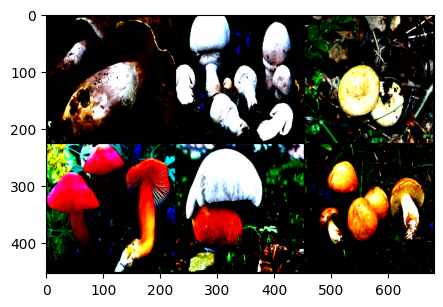

<IPython.core.display.Javascript object>

In [ ]:
show_transformed_images(train_dataset)

* Showing how ResNet18 original model looks like, and we will change the final Linear layer do add our dataset to make mushroom species prediction:

In [ ]:
resnet18_model.to('cpu')  # Move the model to CPU
summary(resnet18_model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

* Calculating weights for our training dataset:

* Training model without model weights to check the initial performace with default optimizer parameters:

In [38]:
weights = calculate_class_weights(training_path)
print("Class Weights for Training Dataset:",weights)
resnet18_model = models.resnet18( weights=None)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 9
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
class_weights = torch.FloatTensor(weights).to(device)
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.1, momentum=0,
                      weight_decay=0)

Class Weights for Training Dataset: tensor([0.1671, 0.0786, 0.0550, 0.0706, 0.1625, 0.1868, 0.0377, 0.0514, 0.1902])


Epoch number: 1
Training dataset. Got 1045.0 out of 4697 images correctly (22.248%).        Epoch loss: 2.91. Time: 3430.3091
Validation dataset. Got 280 out of 1002 images correctly (27.944%).    Time: 883.9368
Finished epoch 1
Epoch number: 2
Training dataset. Got 1353.0 out of 4697 images correctly (28.806%).        Epoch loss: 2.46. Time: 59.4497
Validation dataset. Got 322 out of 1002 images correctly (32.136%).    Time: 9.1940
Finished epoch 2
Epoch number: 3
Training dataset. Got 1580.0 out of 4697 images correctly (33.638%).        Epoch loss: 2.32. Time: 59.5222
Validation dataset. Got 365 out of 1002 images correctly (36.427%).    Time: 9.4959
Finished epoch 3
Epoch number: 4
Training dataset. Got 1731.0 out of 4697 images correctly (36.853%).        Epoch loss: 2.21. Time: 58.8623
Validation dataset. Got 417 out of 1002 images correctly (41.617%).    Time: 9.2684
Finished epoch 4
Epoch number: 5
Training dataset. Got 1853.0 out of 4697 images correctly (39.451%).        Epoc

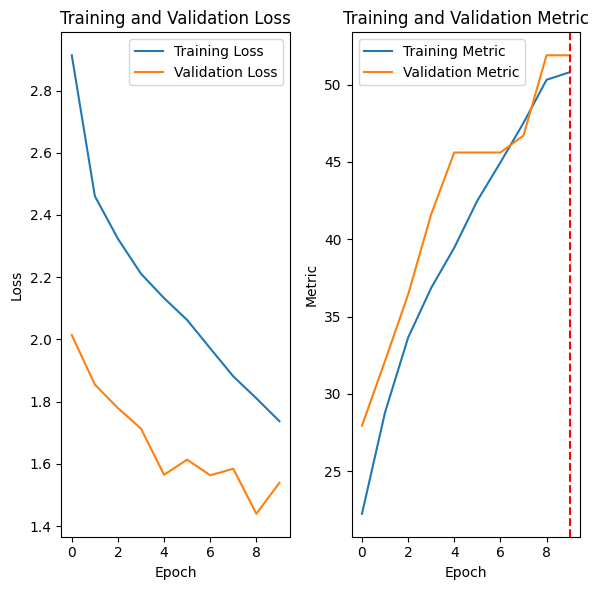

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
train_nn(model=resnet18_model, train_loader=train_loader, validation_loader=validation_loader, criterion=loss_fn, optimizer=optimizer, n_epochs=10, patience=7, class_weights=weights)

* Use SGD optimizer with default ResNet18 weights and default SGD parameters:lr=0.1, momentum=0, weight_decay=0

Class Weights for Training Dataset: tensor([0.1671, 0.0786, 0.0550, 0.0706, 0.1625, 0.1868, 0.0377, 0.0514, 0.1902])
Epoch number: 1
Training dataset. Got 837.0 out of 4697 images correctly (17.820%).        Epoch loss: 3.65. Time: 59.3526
Validation dataset. Got 234 out of 1002 images correctly (23.353%).    Time: 9.2638
Finished epoch 1
Epoch number: 2
Training dataset. Got 900.0 out of 4697 images correctly (19.161%).        Epoch loss: 2.77. Time: 59.4016
Validation dataset. Got 158 out of 1002 images correctly (15.768%).    Time: 9.3174
Finished epoch 2
Epoch number: 3
Training dataset. Got 978.0 out of 4697 images correctly (20.822%).        Epoch loss: 2.65. Time: 59.4269
Validation dataset. Got 234 out of 1002 images correctly (23.353%).    Time: 9.4532
Finished epoch 3
Epoch number: 4
Training dataset. Got 1266.0 out of 4697 images correctly (26.953%).        Epoch loss: 2.47. Time: 59.1852
Validation dataset. Got 346 out of 1002 images correctly (34.531%).    Time: 9.5617
Fin

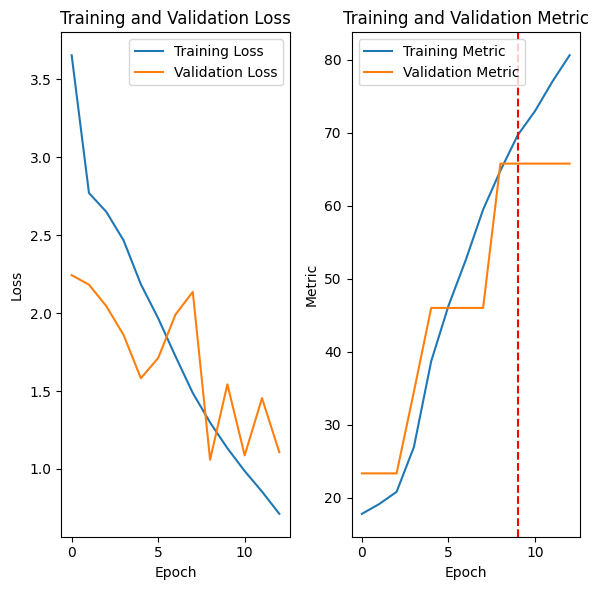

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
weights = calculate_class_weights(training_path)
print("Class Weights for Training Dataset:",weights)
resnet18_model = models.resnet18( weights='DEFAULT')
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 9
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
class_weights = torch.FloatTensor(weights).to(device)
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.1, momentum=0,
                      weight_decay=0)

train_nn(model=resnet18_model, train_loader=train_loader,
         validation_loader=validation_loader, criterion=loss_fn,
         optimizer=optimizer, n_epochs=100, patience=5, class_weights=weights)

* use model with weights, learning_rate=0.001, weight_decay=0.001, momentum=0.9 :

Class Weights for Training Dataset: tensor([0.1671, 0.0786, 0.0550, 0.0706, 0.1625, 0.1868, 0.0377, 0.0514, 0.1902])
Epoch number: 1
Training dataset. Got 2864.0 out of 4697 images correctly (60.975%).        Epoch loss: 1.43. Time: 59.2372
Validation dataset. Got 775 out of 1002 images correctly (77.345%).    Time: 9.5122
Finished epoch 1
Epoch number: 2
Training dataset. Got 3846.0 out of 4697 images correctly (81.882%).        Epoch loss: 0.66. Time: 59.3049
Validation dataset. Got 832 out of 1002 images correctly (83.034%).    Time: 9.4675
Finished epoch 2
Epoch number: 3
Training dataset. Got 4239.0 out of 4697 images correctly (90.249%).        Epoch loss: 0.38. Time: 59.2041
Validation dataset. Got 845 out of 1002 images correctly (84.331%).    Time: 10.0046
Finished epoch 3
Epoch number: 4
Training dataset. Got 4422.0 out of 4697 images correctly (94.145%).        Epoch loss: 0.25. Time: 58.8314
Validation dataset. Got 853 out of 1002 images correctly (85.130%).    Time: 9.4842

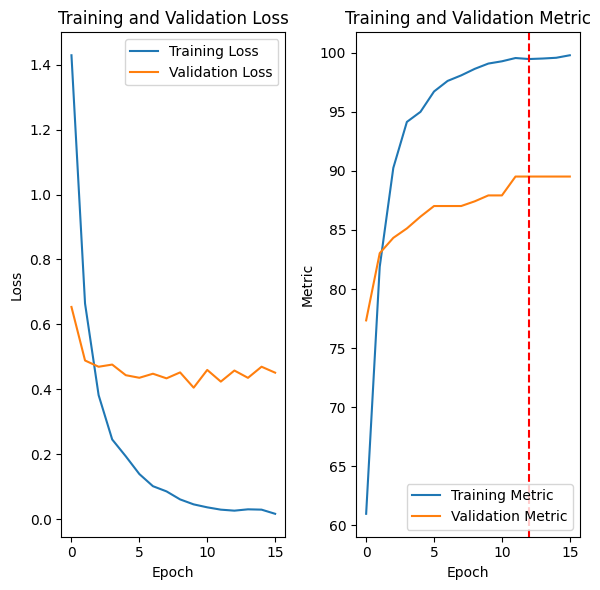

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
weights = calculate_class_weights(training_path)
print("Class Weights for Training Dataset:",weights)
resnet18_model = models.resnet18( weights='DEFAULT')
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 9
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
class_weights = torch.FloatTensor(weights).to(device)
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9,
                      weight_decay=0.001)
train_nn(model=resnet18_model, train_loader=train_loader,
         validation_loader=validation_loader, criterion=loss_fn,
         optimizer=optimizer, n_epochs=50, patience=5, class_weights=weights)

* Use model with weights, change optimizer to AdamW, learning_rate=1e-3, weight_decay=1e-2 (default values):

Class Weights for Training Dataset: tensor([0.1671, 0.0786, 0.0550, 0.0706, 0.1625, 0.1868, 0.0377, 0.0514, 0.1902])
Epoch number: 1
Training dataset. Got 2224.0 out of 4697 images correctly (47.349%).        Epoch loss: 1.97. Time: 59.3753
Validation dataset. Got 492 out of 1002 images correctly (49.102%).    Time: 9.7443
Finished epoch 1
Epoch number: 2
Training dataset. Got 2867.0 out of 4697 images correctly (61.039%).        Epoch loss: 1.45. Time: 59.2364
Validation dataset. Got 589 out of 1002 images correctly (58.782%).    Time: 9.0891
Finished epoch 2
Epoch number: 3
Training dataset. Got 3207.0 out of 4697 images correctly (68.278%).        Epoch loss: 1.20. Time: 59.4289
Validation dataset. Got 623 out of 1002 images correctly (62.176%).    Time: 9.1148
Finished epoch 3
Epoch number: 4
Training dataset. Got 3364.0 out of 4697 images correctly (71.620%).        Epoch loss: 1.06. Time: 59.5090
Validation dataset. Got 659 out of 1002 images correctly (65.768%).    Time: 9.1895


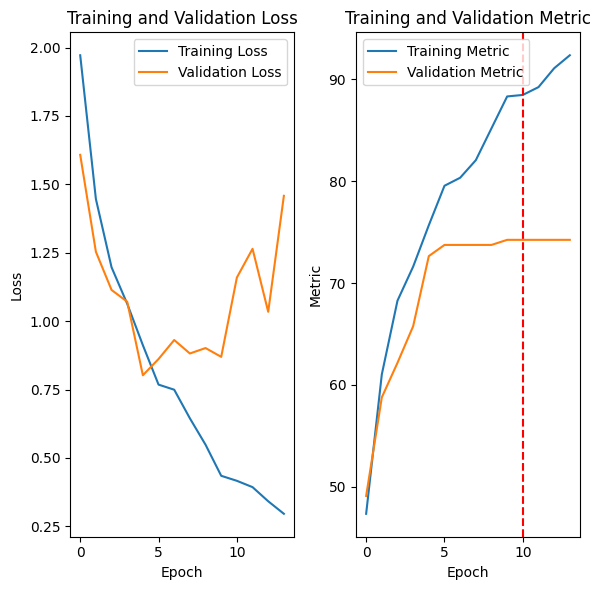

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
weights = calculate_class_weights(training_path)
print("Class Weights for Training Dataset:",weights)
resnet18_model = models.resnet18( weights='DEFAULT')
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 9
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
class_weights = torch.FloatTensor(weights).to(device)
optimizer = optim.AdamW(resnet18_model.parameters(), lr=1e-3,
                        betas=(0.9, 0.999), weight_decay=1e-2)

train_nn(model=resnet18_model, train_loader=train_loader,
         validation_loader=validation_loader, criterion=loss_fn,
         optimizer=optimizer, n_epochs=100, patience=5, class_weights=weights)


* Use model with weights, change optimizer to AdamW, learning_rate=0.001, weight_decay=0.001 (these parameters are picked at random):

Class Weights for Training Dataset: tensor([0.1671, 0.0786, 0.0550, 0.0706, 0.1625, 0.1868, 0.0377, 0.0514, 0.1902])
Epoch number: 1
Training dataset. Got 2285.0 out of 4697 images correctly (48.648%).        Epoch loss: 1.93. Time: 59.6854
Validation dataset. Got 579 out of 1002 images correctly (57.784%).    Time: 9.6455
Finished epoch 1
Epoch number: 2
Training dataset. Got 2894.0 out of 4697 images correctly (61.614%).        Epoch loss: 1.42. Time: 59.8466
Validation dataset. Got 343 out of 1002 images correctly (34.232%).    Time: 9.2840
Finished epoch 2
Epoch number: 3
Training dataset. Got 3175.0 out of 4697 images correctly (67.596%).        Epoch loss: 1.20. Time: 60.0322
Validation dataset. Got 687 out of 1002 images correctly (68.563%).    Time: 9.1987
Finished epoch 3
Epoch number: 4
Training dataset. Got 3399.0 out of 4697 images correctly (72.365%).        Epoch loss: 1.02. Time: 59.6316
Validation dataset. Got 716 out of 1002 images correctly (71.457%).    Time: 9.3643


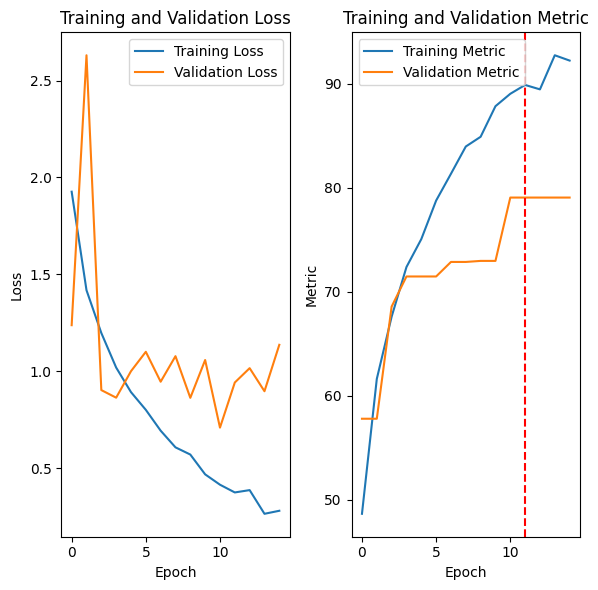

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
weights = calculate_class_weights(training_path)
print("Class Weights for Training Dataset:",weights)
resnet18_model = models.resnet18( weights='DEFAULT')
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 9
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
class_weights = torch.FloatTensor(weights).to(device)
optimizer = optim.AdamW(resnet18_model.parameters(), lr=0.001,
                        betas=(0.9, 0.999), weight_decay=0.001)
train_nn(model=resnet18_model, train_loader=train_loader,
         validation_loader=validation_loader, criterion=loss_fn,
         optimizer=optimizer, n_epochs=100, patience=5, class_weights=weights)

# Conclusions:
From our model training we see that best results validation dataset best accuracy is 89.521%  we get from using pretrained Resnet18 model with these parameters:
* optimizer - SGD (stochastic gradient descent)
* learning_rate - 0.001
* momentum - 0.9
* weight_decay - 0.001
So, further I will check it with my test dataset.

In [49]:
checkpoint = torch.load('model_best_performace.pth.tar')

In [50]:
print('Model best accuracy: ', checkpoint['best_accuracy'])

Model best accuracy:  89.52095808383234


In [51]:
# loading pre-saved trained model: and saving best model:
resnet18_model = models.resnet18( weights='DEFAULT')
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 9
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])
torch.save(resnet18_model, 'best_model.pth')

Class Weights for Training Dataset: tensor([0.1671, 0.0786, 0.0550, 0.0706, 0.1625, 0.1868, 0.0377, 0.0514, 0.1902])
Epoch number: 1
Training dataset. Got 2322.0 out of 4697 images correctly (49.436%).        Epoch loss: 1.89. Time: 45.8811
Validation dataset. Got 647 out of 1002 images correctly (64.571%).    Time: 9.5893
Finished epoch 1
Epoch number: 2
Training dataset. Got 2957.0 out of 4697 images correctly (62.955%).        Epoch loss: 1.40. Time: 45.6446
Validation dataset. Got 693 out of 1002 images correctly (69.162%).    Time: 9.5790
Finished epoch 2
Epoch number: 3
Training dataset. Got 3138.0 out of 4697 images correctly (66.809%).        Epoch loss: 1.25. Time: 45.4386
Validation dataset. Got 697 out of 1002 images correctly (69.561%).    Time: 9.5054
Finished epoch 3
Epoch number: 4
Training dataset. Got 3123.0 out of 4697 images correctly (66.489%).        Epoch loss: 1.21. Time: 45.2870
Validation dataset. Got 719 out of 1002 images correctly (71.756%).    Time: 9.6036


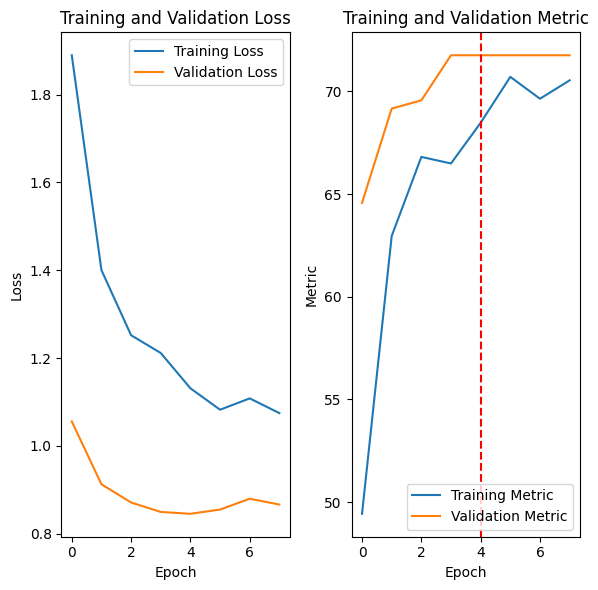

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
best_model_path = '/content/drive/MyDrive/best_model.pth'
best_model = torch.load(best_model_path )
weights = calculate_class_weights(training_path)
print("Class Weights for Training Dataset:",weights)
best_model = models.resnet18( weights='DEFAULT')
for param in best_model.parameters():
    param.requires_grad = False
num_ftrs = best_model.fc.in_features
number_of_classes = 9
best_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
best_model = best_model.to(device)
loss_fn = nn.CrossEntropyLoss()
class_weights = torch.FloatTensor(weights).to(device)
optimizer = optim.SGD(best_model.parameters(), lr=0.001, momentum=0.9,
                      weight_decay=0.001)

train_nn(model=best_model, train_loader=train_loader,
         validation_loader=validation_loader, criterion=loss_fn,
         optimizer=optimizer, n_epochs=100, patience=5, class_weights=weights)

Testing Accuracy: 69.75%. Time: 722.2103


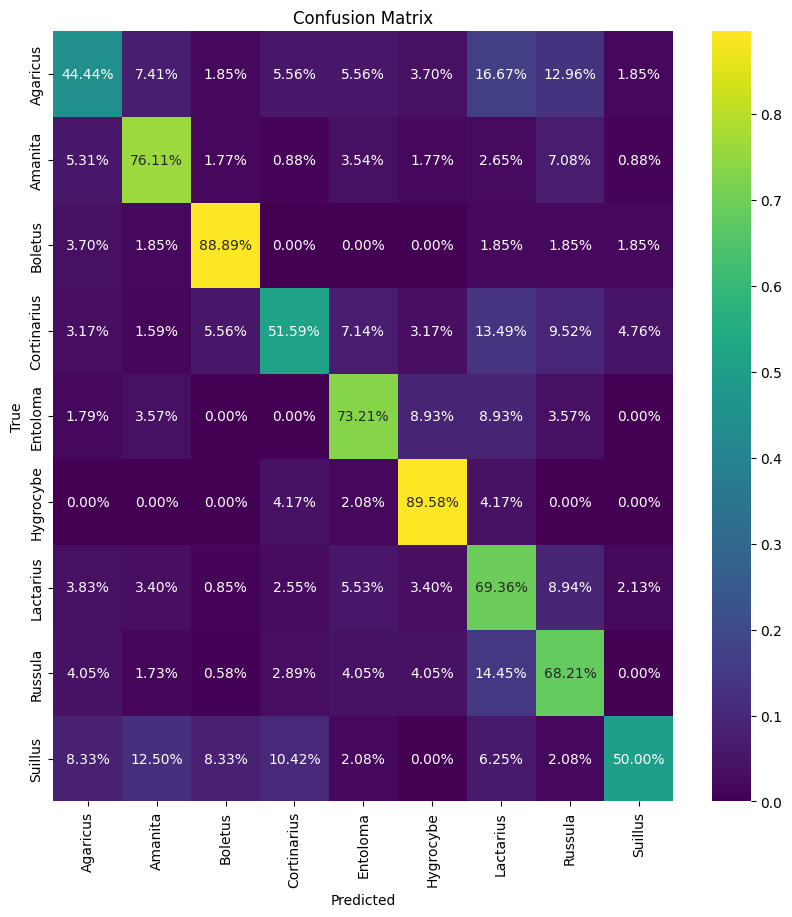

In [54]:
test_accuracy = evaluate_best_model_on_test_set(best_model, test_loader)

* Plotting random images from dataset and prediction results:

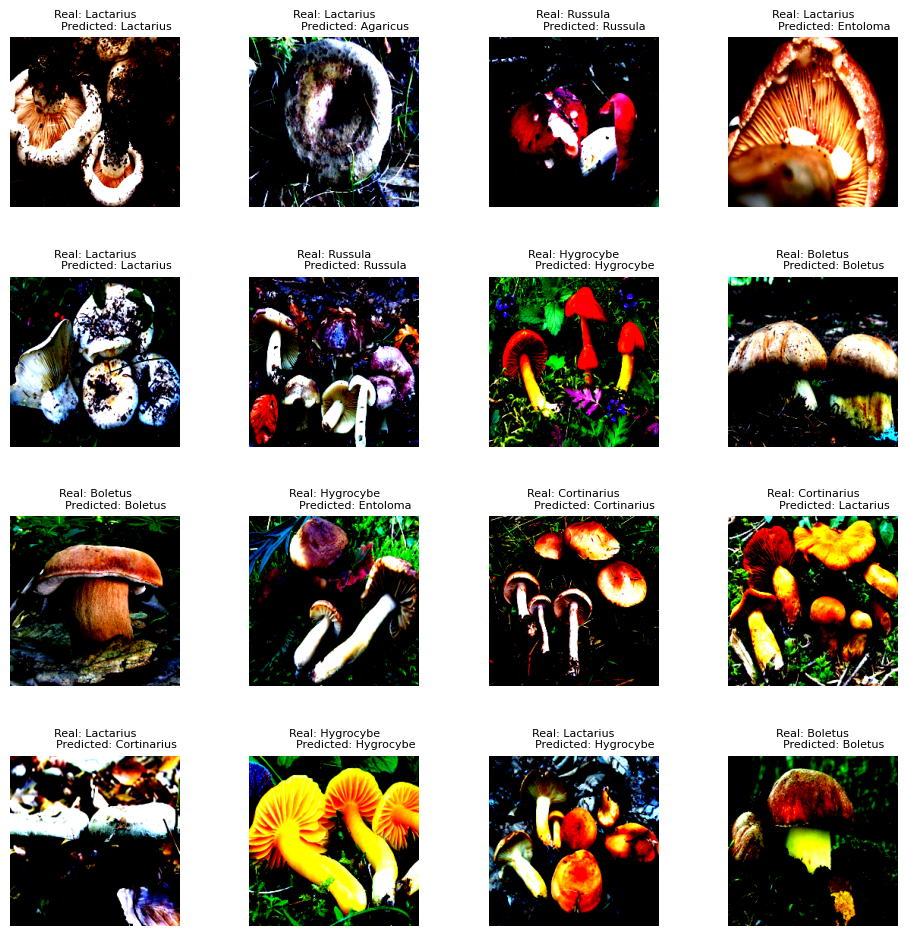

In [55]:
plot_random_images_after_testing(best_model, test_loader)

Conclusion:
For initial NN modeling project I get these results on test dataset:

* best results were achieved using optimizer - SGD (stochastic gradient descent)
* best learning_rate - 0.001
* used momentum - 0.9
* best weight_decay - 0.001
* final testing Accuracy: 69.75%
* From provided confusion matrix we see that best predicted 3 classes out of 9 are:
- Hygrocybe (89.58%)
- Boletus (88.89%)
- Amanita (76.11%).
* Interestingly these groups have unequal image quantity in our dataset: Boletus are 1073 images, Hygrocybe are 316 images, Amanita are 750 image.


Improvements:
* Require further study of NN and fine tuning.
* Require to further study of imbalanced dataset class weights implementation.